# Necessary Imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import PIL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load VGG-19 Pretrained-Model

In [4]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False

# Content Loss

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])


    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)


    return J_content

# Gram Matrix



In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A))
    return GA

# Style Cost of one layer

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()


    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))

    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)


    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))


    return J_style_layer

# VGG-19 model layers

In [8]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
vgg.get_layer('block5_conv2').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv2')>

In [30]:
STYLE_LAYERS = [
    ('block1_conv1', 0.1),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.4),
    ('block4_conv1', 0.1),
    ('block5_conv1', 0.2)]

# Total Style Loss

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [11]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- vgg model outputs
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    a_S = style_image_output[1:]


    a_G = generated_image_output[1:]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

# Total Cost

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [12]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style


    return J

# Load Content and Style Images

(1, 400, 400, 3)


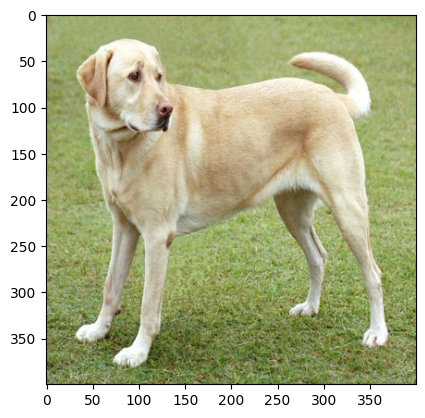

In [13]:
content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/images/YellowLabradorLooking_new.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


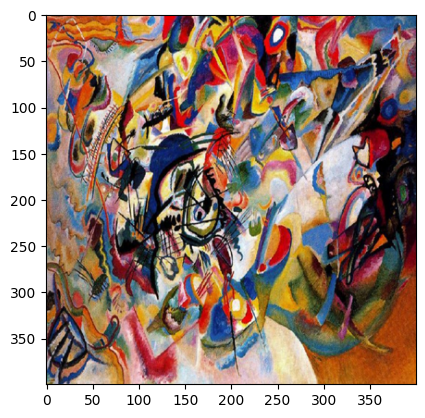

In [14]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/images/Vassily_Kandinsky,_1913_-_Composition_7.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

# Random generated image

(1, 400, 400, 3)


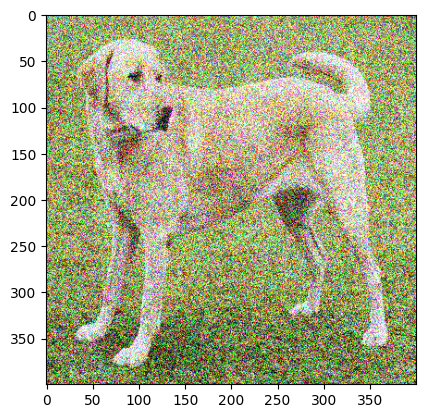

In [15]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.5, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

# Getting activations from VGG-19 of content and style image

In [16]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [31]:
content_layer = [('block5_conv2', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [18]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [19]:

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [20]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# Train Step

In [41]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# total_variation_weight = 30

@tf.function()
def train_step(generated_image, a_C, a_S, alpha = 20, beta = 30):
    with tf.GradientTape() as tape:

        a_G = vgg_model_outputs(generated_image)


        J_style = compute_style_cost(a_S, a_G)


        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)
        # J += total_variation_weight*tf.image.total_variation(generated_image)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

In [25]:
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
epochs = 2501
for i in range(epochs):
    train_step(generated_image, a_C, a_S)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/output/image_{i}.jpg")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Generated image through style transfer

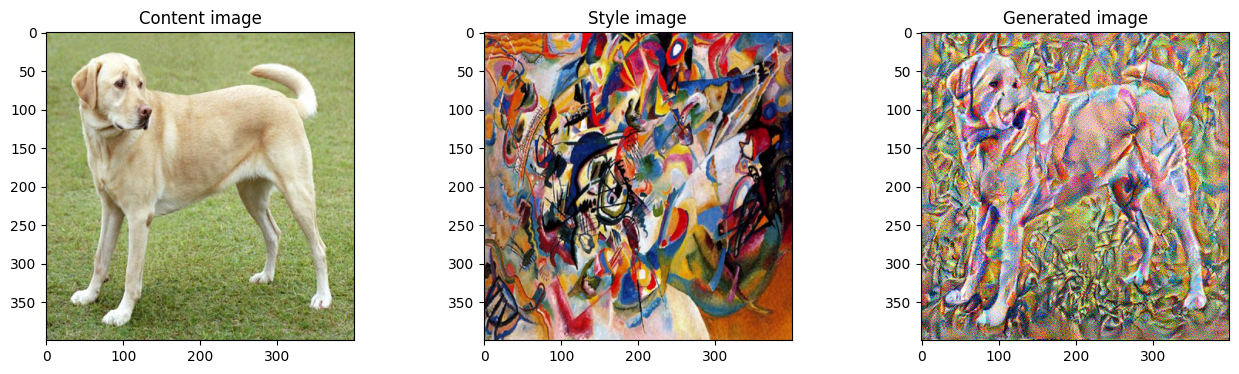

In [26]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

# Another example

In [42]:
content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/images/persian_cat.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()


style_image =  np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/images/stone_style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
# noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
# generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)


preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)


generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
epochs = 2501
for i in range(epochs):
    train_step(generated_image, a_C, a_S)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/Colab Notebooks/Neural_Style_Transfer/output/image_2_{i}.jpg")
        plt.show()


# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## We can tune different hyperparameters(alpha, beta, weights of each layer in style Cost) to change the texture and style.